<h3>Slopes for real videos

13.06.2022

In [1]:
import numpy as np
import cv2 as cv
import scipy
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
import os
import shutil
from skimage.morphology import skeletonize
import skimage.io
from sklearn.mixture import GaussianMixture as GMM
from sklearn.linear_model import LinearRegression

from functions import *
#from wave_detection.line_detection_gmm import *

In [2]:
def cross_correlation (frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=False):
    image_1_name = os.fsdecode(os.listdir(path_to_images)[0])
    image_1 = cv.imread(path_to_images + f'{image_1_name}', cv.IMREAD_GRAYSCALE)
    corr_full_x = np.zeros([image_1.shape[1], frNum])
    corr_full_y = np.zeros([image_1.shape[0], frNum])
    k=0
    while k<frNum:
        image_name = str(k) + '.jpg'
        image_next = cv.imread(path_to_images+f'{image_name}', cv.IMREAD_GRAYSCALE)
        if x_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[pixel[0], :], arr_1, mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[1],)) #normalization added
            corr_full_x[:, k] = corr
        if y_disp:
            arr_1 = np.ones([kernel,]) * image_1[pixel[0], pixel[1]]
            corr = signal.correlate(image_next[:, pixel[1]], np.transpose(arr_1), mode='same')
            corr = np.reshape(cv.normalize(corr, None, 1, 256, cv.NORM_MINMAX), (image_1.shape[0],)) #normalization added
            corr_full_y[:, k] = corr          
        k+=1
    
    return corr_full_x, corr_full_y

In [3]:
""" Estimate the slope of a passing wave
on a position-time plot
Directly copied from the script so it has duplicates - to be fixed
"""
# Github: hubernikus

import numpy as np
from numpy import linalg

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
from sklearn.cluster import DBSCAN


class WaveDetector:
    def __init__(self, corr_image, peak_threshold=150):
    # def __init__(self, data_file, peak_threshold=30):    
        # self.correlation = np.genfromtxt(data_file, delimiter=',')
        self.correlation = corr_image

        self.n_pos = self.correlation.shape[0]
        self.n_time = self.correlation.shape[1]

        # Extract wave tip points with corresponding range of [0, 1] for position and time
        self.ind_siginificant = (self.correlation > peak_threshold)
        # self.ind_siginificant = (self.correlation < peak_threshold)

        # Step-size of 1 between position and time worked out to be optimal
        self.x_lim = [0, self.n_time]
        self.y_lim = [0, self.n_pos]
        
        time_vals, pos_vals = np.meshgrid(
            np.linspace(self.x_lim[0], self.x_lim[-1], self.n_time),
            np.linspace(self.y_lim[0], self.y_lim[-1], self.n_pos),
        )

        self.data = np.vstack((
            time_vals.flatten(),
            pos_vals.flatten(),
            # time_vals.flatten(),
        ))[:, self.ind_siginificant.flatten()]

        # self.data = self.data.T
        #self.do_dbscan()
        self.do_gmm_clustering()
    
    def do_dbscan(self, eps = 2, min_samples = 5, x_stretching = 1, do_plotting = False):
        self.temp_data = np.copy(self.data)
        self.temp_data[0,:] = self.data[0,:]*x_stretching
        self.dbscan = DBSCAN(eps = eps, min_samples = min_samples).fit(self.temp_data.T)
        self.unique_labels = set(self.dbscan.labels_)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(self.unique_labels))]
        
        for k, col in zip(self.unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = self.dbscan.labels_ == k

            xy = self.temp_data.T[class_member_mask]
            if do_plotting:
                plt.plot(
                    xy[:, 0],
                    xy[:, 1],
                    ".",
                    color=tuple(col),
                    markersize=14,
                    )
                plt.axis('equal')
            
    def do_linear_regression(self):
        reg_coeffs = []

        for label in self.unique_labels:
            if label == -1:
                continue

            class_member_mask = self.dbscan.labels_ == label

            xy = self.data.T[class_member_mask]
            reg = LinearRegression().fit(xy[:,0].reshape(-1, 1), xy[:,1].reshape(-1, 1))
            reg_coeffs.append(reg.coef_)

        return np.mean(reg_coeffs)

        
    def do_gmm_clustering(self, n_gmm=4):
        self.gmm = mixture.GaussianMixture(
            n_components=n_gmm,
            covariance_type="full",
            max_iter=100
        ).fit(self.data.T)
        
    


    def do_slope_estimation(self, rel_weight_margin=0.1, color='#ADD8E6', plot_results=False):
        # TODO: Pre-processing to remove ellipses which are in the upper left or bottom -> Done
        # self.count = []

        # for ii, mean in enumerate(self.gmm.means_):
        #     if mean[1] <= self.n_pos/2 and mean[0] <= self.n_time/3:
        #     # if mean[1] >= 80:
        #         self.count.append(ii)
        # self.gmm.means_ = np.delete(self.gmm.means_, self.count, 0)
        # self.gmm.covariances_ = np.delete(self.gmm.covariances_, self.count, 0)
        # self.gmm.weights_ = np.delete(self.gmm.weights_, self.count, 0)

        
        max_weight = np.max(self.gmm.weights_)

        if plot_results:
            # Plot only relevant clusters
            fig, ax = plt.subplots()

        self.slopes = []
        self.weights = []
        
        for ii, (mean, covar) in enumerate(zip(self.gmm.means_, self.gmm.covariances_)):
            # Neglect clusteres with only few points
            if self.gmm.weights_[ii] < rel_weight_margin * max_weight:
                continue
    
            # Eigen values are in ascending order -> last eigenvector is important!
            eig_vals, eig_vecs = linalg.eigh(covar)

            eig_vals = 2.0 * np.sqrt(2.0) * np.sqrt(eig_vals)
            uu = eig_vecs[0] / linalg.norm(eig_vecs[0])

            if any(eig_vecs[-1, :] < 1e-3):
                continue
            elif any(eig_vecs[-1, :] > 100):
                continue
            self.weights.append(self.gmm.weights_[ii])
            self.slopes.append(eig_vecs[-1, :] / linalg.norm(eig_vecs[-1, :]))
                    # self.slopes.append([-uu[1], uu[0]])

            if plot_results:
                        # Plot an ellipse to show the Gaussian component
                        angle = np.arctan2(uu[1], uu[0])
                        angle = 180.0 * angle / np.pi  # convert to degrees
                        ell = mpl.patches.Ellipse(mean, eig_vals[0], eig_vals[1], angle, color=color)
                        ell.set_clip_box(ax.bbox)
                        ell.set_alpha(0.5)
                        ax.add_artist(ell)
                
                # Get mean
            self.slopes = np.array(self.slopes).T

                # Check which slopes are pointing downwards
            ind_neg = (self.slopes[1, :] < 0)
            self.slopes[1, ind_neg] *= (-1)

                # Normalize weights
            self.weights = self.weights / np.sum(self.weights)
                
            self.mean_slope = np.sum(
                self.slopes * np.tile(self.weights, (self.slopes.shape[0], 1)), axis=1
                )

            slope = self.mean_slope[1] / self.mean_slope[0]

            if plot_results:
                    ax.scatter(self.data[0, :], self.data[1, :], color='k')
                    # ax.scatter([], [], color='k')
                    self.x_lim = ax.get_xlim()
                    self.y_lim = ax.get_ylim()

                    y1 = self.y_lim[0] + (self.x_lim[1] - self.x_lim[0]) * slope

                    ax.plot(self.x_lim, np.array([self.y_lim[0], y1]) + 0, '--', color='r',
                            linewidth=2, label=f"{round(slope, 6)} m / s")

                    ax.set_xlim(self.x_lim)
                    ax.set_ylim(self.y_lim)

                    ax.legend()

            return slope

    def plot_all_clusters(self, color='#ADD8E6'):
        fig, ax = plt.subplots()

        ax.scatter(self.data[0, :], self.data[1, :], color='k')
        
        for ii, (mean, covar) in enumerate(zip(self.gmm.means_, self.gmm.covariances_)):
            v, w = linalg.eigh(covar)
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            
            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

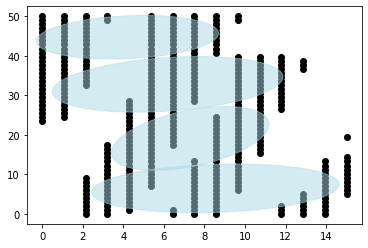

In [12]:
plt.close('all')
plt.ion()
# my_detector = WaveDetector(data_file="corr_0_40.csv")
my_detector = WaveDetector(corr_image=blur_norm)
my_detector.plot_all_clusters()
# my_detector.do_gmm_clustering()
#slope = my_detector.do_slope_estimation(plot_results=True)
#print('slope', slope)

(-3.0, 63.0, -2.5, 52.5)

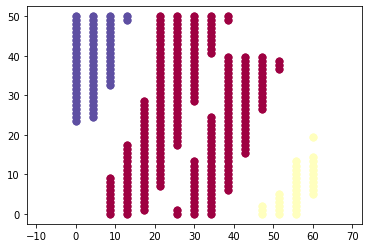

In [13]:
my_detector.do_dbscan(eps =8, min_samples = 12, x_stretching = 4, do_plotting = True)
unique_labels = set(my_detector.dbscan.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = my_detector.dbscan.labels_ == k

    xy = my_detector.temp_data.T[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        ".",
        color=tuple(col),
        markersize=14,
    )
plt.axis('equal')    

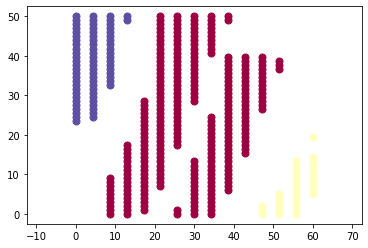

In [14]:
my_detector = WaveDetector(corr_image=blur_norm)
my_detector.do_dbscan(eps =8, min_samples = 12, x_stretching = 4, do_plotting = True)

In [15]:
reg_coeffs = []

for label in unique_labels:
    if k == -1:
        continue

    class_member_mask = my_detector.dbscan.labels_ == label

    xy = my_detector.data.T[class_member_mask]
    reg = LinearRegression().fit(xy[:,0].reshape(-1, 1), xy[:,1].reshape(-1, 1))
    reg_coeffs.append(reg.coef_)
    
np.mean(reg_coeffs)
    #reg.intercept_

2.5085933496050656

In [17]:
# calculate elasticity

def elasticity_HT (slopes, dens, conv_pix, conv_fr):
    conv_factor = (conv_pix * conv_fr)
    mu = ((slopes * conv_factor)**2) * dens
    return mu

In [ ]:
# extracting frames from the video of a real wave with subtracted mean (2 percent conc), smoothed version

video_name = 'Result of 20kHz_400mV_100kfps_384by240_20x_C001H001S0001-cut_50fr_subs-cleaned'
path_to_source = 'data/' + video_name + '.avi'
cap = cv.VideoCapture(path_to_source)
num_frames = 50
l=0
m=0
while l <= num_frames:
    ret, frame = cap.read()
    if not ret: 
        print('No frames grabbed!')
        break
    cv.imwrite(f'real_1306/{m}.jpg', frame)
    l+=1
    m+=1

In [ ]:
os.mkdir('real_1306')
os.mkdir('real_1306_crop')
os.mkdir('real_1306_crop_slow')

In [6]:
# crop images for faster calculation 

data_path = 'real_1306/'
data_save = 'real_1306_crop/'
x_start = 50
x_end = 100
y_start = 5
y_end = 55
crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False)

In [7]:
# function to skip some frames

for i in range(0, len(os.listdir('real_1306_crop')), 3):
    img = cv.imread(f'real_1306_crop/{i}.jpg')
    cv.imwrite(f'real_1306_crop_slow/{int(i/3)}.jpg', img) # name depends on the number of frames to skip

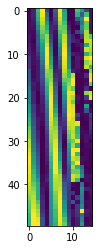

In [8]:
# implement slope measurement for one pixel (I used the following cells to control the situation for different pixels)

frNum = 15
path_to_images = 'real_1306_crop_slow/'
kernel = 1
threshold_bin = 0
pixel = [0, 5]
_, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)

plt.imshow(corr_full_y)

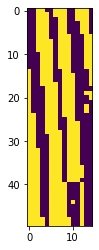

In [9]:
# plt.hist(corr_full_y.ravel())
T=50
image = np.copy(corr_full_y)
image[corr_full_y<T] = 0
image[corr_full_y>=T] = 1
plt.imshow(image)

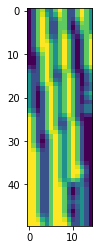

In [10]:
# trying preprocessing

# dil = skimage.morphology.closing(image)
# blur_med = cv.medianBlur(corr_full_y, 3)
blur = cv.GaussianBlur(image, (3, 3), 0)
# skeleton = skeletonize(dil)
plt.imshow(blur)

In [11]:
blur_norm = cv.normalize(blur, None, 0, 255, cv.NORM_MINMAX)

[0, 0]
[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 5]
[0, 6]
[0, 7]
[0, 8]
[0, 9]
[0, 10]
[0, 11]
[0, 12]
[0, 13]
[0, 14]
[0, 15]
[0, 16]
[0, 17]
[0, 18]
[0, 19]
[0, 20]
[0, 21]
[0, 22]
[0, 23]
[0, 24]
[0, 25]
[0, 26]
[0, 27]
[0, 28]
[0, 29]
[0, 30]
[0, 31]
[0, 32]
[0, 33]
[0, 34]
[0, 35]
[0, 36]
[0, 37]
[0, 38]
[0, 39]
[0, 40]
[0, 41]
[0, 42]
[0, 43]
[0, 44]
[0, 45]
[0, 46]
[0, 47]
[0, 48]
[0, 49]
[1, 0]
[1, 1]
[1, 2]
[1, 3]
[1, 4]
[1, 5]
[1, 6]
[1, 7]
[1, 8]
[1, 9]
[1, 10]
[1, 11]
[1, 12]
[1, 13]
[1, 14]
[1, 15]
[1, 16]
[1, 17]
[1, 18]
[1, 19]
[1, 20]
[1, 21]
[1, 22]
[1, 23]
[1, 24]
[1, 25]
[1, 26]
[1, 27]
[1, 28]
[1, 29]
[1, 30]
[1, 31]
[1, 32]
[1, 33]
[1, 34]
[1, 35]
[1, 36]
[1, 37]
[1, 38]
[1, 39]
[1, 40]
[1, 41]
[1, 42]
[1, 43]
[1, 44]
[1, 45]
[1, 46]
[1, 47]
[1, 48]
[1, 49]
[2, 0]
[2, 1]
[2, 2]
[2, 3]
[2, 4]
[2, 5]
[2, 6]
[2, 7]
[2, 8]
[2, 9]
[2, 10]
[2, 11]
[2, 12]
[2, 13]
[2, 14]
[2, 15]
[2, 16]
[2, 17]
[2, 18]
[2, 19]
[2, 20]
[2, 21]
[2, 22]
[2, 23]
[2, 24]
[2, 25]
[2, 26]
[2, 27]
[2, 28

[19, 39]
[19, 40]
[19, 41]
[19, 42]
[19, 43]
[19, 44]
[19, 45]
[19, 46]
[19, 47]
[19, 48]
[19, 49]
[20, 0]
[20, 1]
[20, 2]
[20, 3]
[20, 4]
[20, 5]
[20, 6]
[20, 7]
[20, 8]
[20, 9]
[20, 10]
[20, 11]
[20, 12]
[20, 13]
[20, 14]
[20, 15]
[20, 16]
[20, 17]
[20, 18]
[20, 19]
[20, 20]
[20, 21]
[20, 22]
[20, 23]
[20, 24]
[20, 25]
[20, 26]
[20, 27]
[20, 28]
[20, 29]
[20, 30]
[20, 31]
[20, 32]
[20, 33]
[20, 34]
[20, 35]
[20, 36]
[20, 37]
[20, 38]
[20, 39]
[20, 40]
[20, 41]
[20, 42]
[20, 43]
[20, 44]
[20, 45]
[20, 46]
[20, 47]
[20, 48]
[20, 49]
[21, 0]
[21, 1]
[21, 2]
[21, 3]
[21, 4]
[21, 5]
[21, 6]
[21, 7]
[21, 8]
[21, 9]
[21, 10]
[21, 11]
[21, 12]
[21, 13]
[21, 14]
[21, 15]
[21, 16]
[21, 17]
[21, 18]
[21, 19]
[21, 20]
[21, 21]
[21, 22]
[21, 23]
[21, 24]
[21, 25]
[21, 26]
[21, 27]
[21, 28]
[21, 29]
[21, 30]
[21, 31]
[21, 32]
[21, 33]
[21, 34]
[21, 35]
[21, 36]
[21, 37]
[21, 38]
[21, 39]
[21, 40]
[21, 41]
[21, 42]
[21, 43]
[21, 44]
[21, 45]
[21, 46]
[21, 47]
[21, 48]
[21, 49]
[22, 0]
[22, 1]
[22, 

[38, 21]
[38, 22]
[38, 23]
[38, 24]
[38, 25]
[38, 26]
[38, 27]
[38, 28]
[38, 29]
[38, 30]
[38, 31]
[38, 32]
[38, 33]
[38, 34]
[38, 35]
[38, 36]
[38, 37]
[38, 38]
[38, 39]
[38, 40]
[38, 41]
[38, 42]
[38, 43]
[38, 44]
[38, 45]
[38, 46]
[38, 47]
[38, 48]
[38, 49]
[39, 0]
[39, 1]
[39, 2]
[39, 3]
[39, 4]
[39, 5]
[39, 6]
[39, 7]
[39, 8]
[39, 9]
[39, 10]
[39, 11]
[39, 12]
[39, 13]
[39, 14]
[39, 15]
[39, 16]
[39, 17]
[39, 18]
[39, 19]
[39, 20]
[39, 21]
[39, 22]
[39, 23]
[39, 24]
[39, 25]
[39, 26]
[39, 27]
[39, 28]
[39, 29]
[39, 30]
[39, 31]
[39, 32]
[39, 33]
[39, 34]
[39, 35]
[39, 36]
[39, 37]
[39, 38]
[39, 39]
[39, 40]
[39, 41]
[39, 42]
[39, 43]
[39, 44]
[39, 45]
[39, 46]
[39, 47]
[39, 48]
[39, 49]
[40, 0]
[40, 1]
[40, 2]
[40, 3]
[40, 4]
[40, 5]
[40, 6]
[40, 7]
[40, 8]
[40, 9]
[40, 10]
[40, 11]
[40, 12]
[40, 13]
[40, 14]
[40, 15]
[40, 16]
[40, 17]
[40, 18]
[40, 19]
[40, 20]
[40, 21]
[40, 22]
[40, 23]
[40, 24]
[40, 25]
[40, 26]
[40, 27]
[40, 28]
[40, 29]
[40, 30]
[40, 31]
[40, 32]
[40, 33]
[40

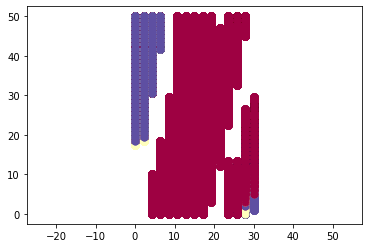

In [18]:
# Trying cropped simulated video (good video, 2 percent conc)

frNum = 15
path_to_images = 'real_1306_crop_slow/'
kernel = 1
threshold_bin = 0
image_1 = cv.imread(path_to_images + '0.jpg', cv.IMREAD_GRAYSCALE)
slopes = np.zeros([image_1.shape[0], image_1.shape[1]])

for i in range(image_1.shape[0]):
    for j in range(image_1.shape[1]):
        pixel=[i, j]
        print(pixel)
        try:
            _, corr_full_y = cross_correlation(frNum, path_to_images, pixel, kernel, x_disp=False, y_disp=True)
        
            T=50
            image = np.copy(corr_full_y)
            image[corr_full_y<T] = 0
            image[corr_full_y>=T] = 1
            blur = cv.GaussianBlur(image, (3, 3), 0)
            blur_norm = cv.normalize(blur, None, 0, 255, cv.NORM_MINMAX)
            my_detector = WaveDetector(corr_image=blur_norm)
            my_detector.do_dbscan(eps =5, min_samples = 10, x_stretching = 2, do_plotting = True)
            slope = my_detector.do_linear_regression()
        except ValueError:
            slope=None
        slopes[i, j] = slope

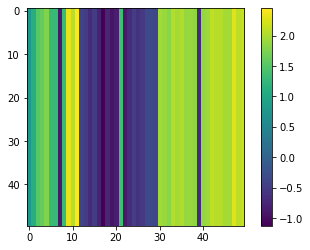

In [19]:
plt.imshow(slopes)
plt.colorbar()

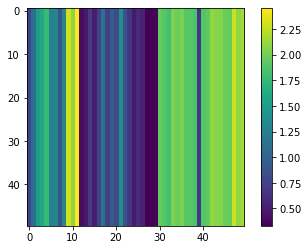

In [20]:
new_slopes = slopes
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        if new_slopes[i,j]<0:
            new_slopes[i,j] *= -1
plt.imshow(new_slopes)
plt.colorbar()

In [21]:
# Get rid of nan values

nan_array = np.isnan(new_slopes)
not_nan_array = ~ nan_array
slope_notnan = new_slopes[not_nan_array]
replacement = np.median(slope_notnan)
replacement 

1.4434941319855459

In [22]:
for i in range(slopes.shape[0]):
    for j in range(slopes.shape[1]):
        if new_slopes[i,j]>100:
            new_slopes[i,j] = replacement
        elif np.isnan(new_slopes[i,j]):
            new_slopes[i,j] = replacement
new_slopes
median_of_slope_new = np.median(new_slopes)

In [23]:
nan_arrayN = np.isnan(new_slopes)
not_nan_arrayN = ~ nan_arrayN
slope_notnanN = new_slopes[not_nan_arrayN]
median_of_slope_new = np.median(slope_notnanN)
median_of_slope_new

1.4434941319855459

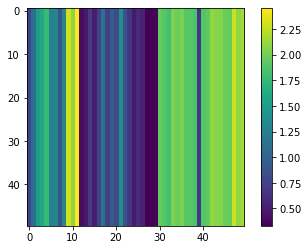

In [24]:
plt.imshow(new_slopes)
plt.colorbar()

In [25]:
# Compute elasticity

dens = 1000
conv_pix = (1/2)*1e-6
conv_fr = 300000

mu = elasticity_HT(new_slopes, dens, conv_pix, conv_fr)

In [26]:
# Get rid of nan values

nan_array = np.isnan(mu)
not_nan_array = ~ nan_array
mu_notnan = mu[not_nan_array]
np.median(mu_notnan)


47.003784294996976

In [27]:
speed = np.sqrt(mu_notnan/dens)
np.median(speed)

0.21652411979783187

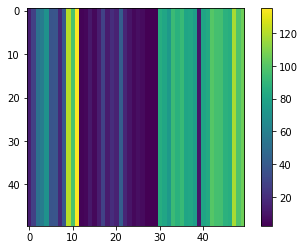

In [28]:
plt.imshow(mu)
plt.colorbar()